In [36]:
import pandas as pd
import numpy as np
from collections import Counter
import spacy
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.tokenize import word_tokenize
import re

# Download required NLTK data
nltk.download('punkt')

# Load the data
df = pd.read_csv('lastt.csv')
print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())


Dataset shape: (27108, 19)

Columns: ['Unnamed: 0', 'Mekan_Adı', 'Kullanıcı_Adı', 'Yorum', 'Puan', 'Yorum_Tarihi', 'Restoran_Kategorisi', 'Restoran_Toplam_Yorum_Sayısı', 'Ortalama_Restoran_Puanı', 'Restoran_Adresi', 'sentiment_score', 'label', 'AI_Result', 'Tat', 'Hizmet', 'Ortam', 'Fiyat-Performans', 'Menü Çeşitliliği', 'Temizlik']


[nltk_data] Downloading package punkt to /Users/Serra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 1.1 Veri Hazırlığı & Temizlik

## 1. Null Değer Kontrolü


In [37]:
# Check null values in each column
null_counts = df.isnull().sum()
print("Null value counts per column:")
print(null_counts)

# Calculate percentage of null values
null_percentages = (null_counts / len(df)) * 100
print("\nNull value percentages per column:")
print(null_percentages)

# List columns with null values
columns_with_nulls = null_counts[null_counts > 0].index.tolist()
print("\nColumns containing null values:", columns_with_nulls)


Null value counts per column:
Unnamed: 0                          0
Mekan_Adı                           0
Kullanıcı_Adı                       0
Yorum                               0
Puan                                0
Yorum_Tarihi                        0
Restoran_Kategorisi                 0
Restoran_Toplam_Yorum_Sayısı        0
Ortalama_Restoran_Puanı             0
Restoran_Adresi                     0
sentiment_score                     3
label                               3
AI_Result                           1
Tat                             10595
Hizmet                          12499
Ortam                           19167
Fiyat-Performans                20356
Menü Çeşitliliği                25165
Temizlik                        23473
dtype: int64

Null value percentages per column:
Unnamed: 0                       0.000000
Mekan_Adı                        0.000000
Kullanıcı_Adı                    0.000000
Yorum                            0.000000
Puan                           

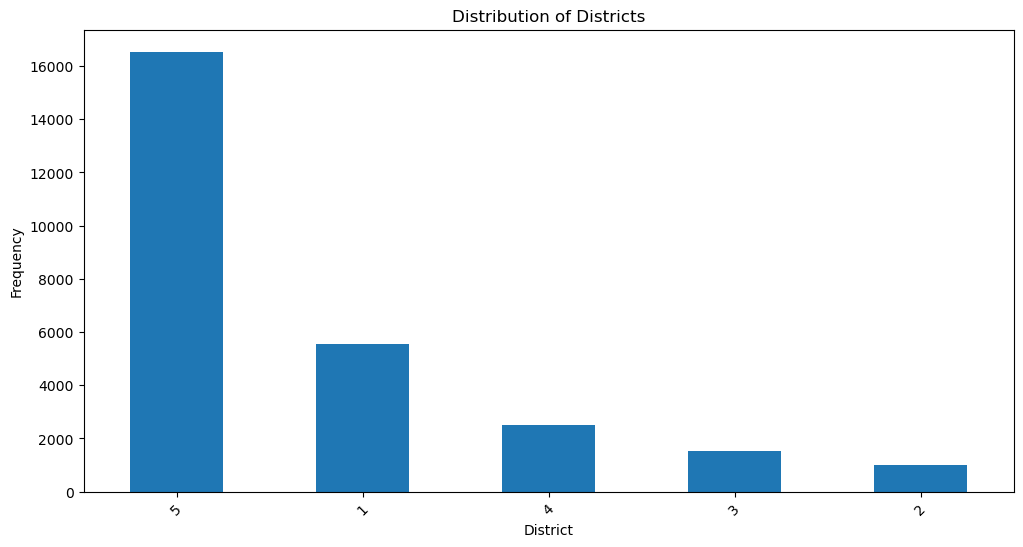

In [38]:
import matplotlib.pyplot as plt

# Visualize the distribution of districts
plt.figure(figsize=(12, 6))
df['Puan'].value_counts().plot(kind='bar')
plt.title('Distribution of Districts')
plt.xlabel('District')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [39]:
df = df.replace('', np.nan)
df = df.dropna(subset=['sentiment_score', 'label', 'AI_Result'], how='any')
null_counts = df.isnull().sum()
print("Null value counts per column:")
print(null_counts)

Null value counts per column:
Unnamed: 0                          0
Mekan_Adı                           0
Kullanıcı_Adı                       0
Yorum                               0
Puan                                0
Yorum_Tarihi                        0
Restoran_Kategorisi                 0
Restoran_Toplam_Yorum_Sayısı        0
Ortalama_Restoran_Puanı             0
Restoran_Adresi                     0
sentiment_score                     0
label                               0
AI_Result                           0
Tat                             10592
Hizmet                          12497
Ortam                           19164
Fiyat-Performans                20353
Menü Çeşitliliği                25161
Temizlik                        23470
dtype: int64


## 2. Kategori Skorlarının Normalizasyonu


In [40]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 27104 entries, 0 to 27107
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    27104 non-null  int64  
 1   Mekan_Adı                     27104 non-null  object 
 2   Kullanıcı_Adı                 27104 non-null  object 
 3   Yorum                         27104 non-null  object 
 4   Puan                          27104 non-null  int64  
 5   Yorum_Tarihi                  27104 non-null  object 
 6   Restoran_Kategorisi           27104 non-null  object 
 7   Restoran_Toplam_Yorum_Sayısı  27104 non-null  int64  
 8   Ortalama_Restoran_Puanı       27104 non-null  float64
 9   Restoran_Adresi               27104 non-null  object 
 10  sentiment_score               27104 non-null  float64
 11  label                         27104 non-null  object 
 12  AI_Result                     27104 non-null  object 
 13  Tat   

In [41]:
col = 'Tat'  # or any column you want
# Try to convert, marking errors as NaN
converted = pd.to_numeric(df[col], errors='coerce')
# Find problematic cells (where conversion failed but value is not null/empty)
problematic = df.loc[converted.isna() & df[col].notna(), col]
print("⚠️ Problematic cells that could not be converted to float:")
print(problematic)


⚠️ Problematic cells that could not be converted to float:
11696    {'Roast beef pizza': 1.0, 'Cannoli tatlısı': -...
19776                                       Balıklar taze.
Name: Tat, dtype: object


In [42]:
cols_to_check = ['Tat', 'Hizmet']
for col in cols_to_check:
    converted = pd.to_numeric(df[col], errors='coerce')
    # Drop problematic rows
    df = df.loc[~(converted.isna() & df[col].notna())].copy()
    # Convert the column to float
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [43]:
df['Tat'] = df['Tat'].astype(float)
df['Hizmet'] = df['Hizmet'].astype(float)

In [44]:
# Assuming we have category score columns, let's normalize them to 0-1 range
# First, identify category score columns (you might need to adjust this based on your actual column names)
# Select columns that contain 'kategori' or 'score' in the name AND are float type
category_columns = [
    col for col in df.columns 
    if  (pd.api.types.is_float_dtype(df[col])) or (pd.api.types.is_integer_dtype(df[col]))]

if category_columns:
    # Min-Max normalization for category scores
    for col in category_columns:
        min_val = df[col].min()
        max_val = df[col].max()
        if pd.notnull(min_val) and pd.notnull(max_val) and max_val != min_val:  # avoid division by zero
            df[f'{col}_normalized'] = (df[col] - min_val) / (max_val - min_val)
            print(f"Normalized {col}: Min={df[f'{col}_normalized'].min():.2f}, Max={df[f'{col}_normalized'].max():.2f}")
        else:
            print(f"Skipped {col}: constant or empty values")
else:
    print("No category score float columns found. Please specify the correct column names.")



Normalized Unnamed: 0: Min=0.00, Max=1.00
Normalized Puan: Min=0.00, Max=1.00
Normalized Restoran_Toplam_Yorum_Sayısı: Min=0.00, Max=1.00
Normalized Ortalama_Restoran_Puanı: Min=0.00, Max=1.00
Normalized sentiment_score: Min=0.00, Max=1.00
Normalized Tat: Min=0.00, Max=1.00
Normalized Hizmet: Min=0.00, Max=1.00
Normalized Ortam: Min=0.00, Max=1.00
Normalized Fiyat-Performans: Min=0.00, Max=1.00
Normalized Menü Çeşitliliği: Min=0.00, Max=1.00
Normalized Temizlik: Min=0.00, Max=1.00


## 3. Adres Parsing (Şehir, İlçe Çıkarma)


In [45]:
import re
import unicodedata
import pandas as pd

# Full list of Turkish provinces (İl)
TR_CITIES = {'ankara','istanbul','izmir'}

def _norm(s: str) -> str:
    """Basic normalize: unicode, collapse spaces, trim."""
    s = unicodedata.normalize("NFKC", str(s))
    s = re.sub(r'\s+', ' ', s).strip(' ,.;-')
    return s

def _clean_piece(s: str) -> str:
    """Drop postal codes & extra symbols from a piece likely holding İlçe."""
    s = re.sub(r'\b\d{4,6}\b', ' ', s)      # remove postal codes like 06490
    s = re.sub(r'[,.;]', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

def _turkish_title(s: str) -> str:
    """Simple title-case that preserves Turkish chars reasonably."""
    # Fix common dotted-i artifacts if present
    s = s.replace('i̇', 'i').replace('İ', 'İ')
    return s.title()

def extract_location_info(address: str):
    """Return (Ilce, Il) with Turkish casing; None, None if not found."""
    if pd.isna(address):
        return None, None

    addr = _norm(address)

    # 1) Strong pattern: "... <ilçe> / <il>" at the END of address
    # Allow letters, Turkish diacritics, dots and spaces in ilçe; only letters in il
    m = re.search(r'([A-Za-zÇĞİIÖŞÜçğıiöşü\.\-\s]+)\s*/\s*([A-Za-zÇĞİIÖŞÜçğıiöşü]+)\s*$', addr)
    if m:
        raw_ilce = _clean_piece(m.group(1))
        raw_il   = _clean_piece(m.group(2))
        il_l = raw_il.lower()
        if il_l in TR_CITIES:
            ilce = _turkish_title(raw_ilce.split()[-1]) if raw_ilce else None
            il   = _turkish_title(raw_il)
            return ilce or None, il

    # 2) No slash? Try to detect a city name near the end of string
    # Find last occurrence of a known city token
    tokens = [t.strip(' ,.;') for t in addr.split()]
    lowers = [t.lower() for t in tokens]
    city_pos = None
    for i in range(len(lowers)-1, -1, -1):
        if lowers[i] in TR_CITIES:
            city_pos = i
            break

    if city_pos is not None:
        il = _turkish_title(tokens[city_pos])
        # Guess district as the closest previous alpha token skipping numbers/abbr
        # e.g., "... 06490 Çankaya Ankara" -> take "Çankaya"
        ilce = None
        for j in range(city_pos-1, -1, -1):
            token = tokens[j]
            if re.fullmatch(r'\d+|no:?|sk\.?|cd\.?|mah\.?|mahallesi', token.lower()):
                continue
            if re.search(r'[A-Za-zÇĞİIÖŞÜçğıiöşü]', token):
                ilce = _turkish_title(token)
                break
        return ilce, il

    # 3) Give up if we can't confidently parse
    return None, None

# ---- Apply to your DataFrame ----
address_column = 'Restoran_Adresi'  # change if needed
if address_column in df.columns:
    pairs = df[address_column].apply(extract_location_info)
    df[['Ilce', 'Il']] = pd.DataFrame(pairs.tolist(), index=df.index)

    # Quick sanity prints
    print("İl dağılımı (top 10):")
    print(df['Il'].value_counts(dropna=True).head(10))
    print("\nİlçe dağılımı (top 10):")
    print(df['Ilce'].value_counts(dropna=True).head(10))
else:
    print(f"Address column '{address_column}' not found. Available columns:", df.columns.tolist())


İl dağılımı (top 10):
Il
Ankara    26206
Name: count, dtype: int64

İlçe dağılımı (top 10):
Ilce
Çankaya          4717
Etimesgut        3626
Keçiören         3218
Altındağ         2962
Mamak            2903
Pursaklar        2421
Beypazarı        1630
Sincan           1460
Kahramankazan    1230
Yenimahalle      1208
Name: count, dtype: int64


In [46]:
#df = df.drop(columns=['extracted_city', 'extracted_district', 'Restoran_Adresi'])
#df

In [47]:
df["Ilce"].value_counts()

Ilce
Çankaya          4717
Etimesgut        3626
Keçiören         3218
Altındağ         2962
Mamak            2903
Pursaklar        2421
Beypazarı        1630
Sincan           1460
Kahramankazan    1230
Yenimahalle      1208
Elmadağ           346
Gölbaşı           175
Eryaman            90
Çayyolu            88
Kalecik            64
35;;A              53
No:66/C            15
Name: count, dtype: int64

In [48]:
# Clean ilçe values
def clean_ilce_values(df):
    # Make a copy to avoid SettingWithCopyWarning
    df = df.copy()
    
    # Replace specific values
    df.loc[df['Ilce'] == '35;;A', 'Ilce'] = 'Mamak'
    df.loc[df['Ilce'] == 'No:66/C', 'Ilce'] = 'BEYPAZARI'
    
    # Make sure all district names have consistent capitalization (Title case)
    df['Ilce'] = df['Ilce'].apply(lambda x: x.title() if isinstance(x, str) else x)
    
    # Count the changes
    mamak_count = (df['Ilce'] == 'Mamak').sum()
    beypazari_count = (df['Ilce'] == 'Beypazari').sum()
    
    print(f"Updated {mamak_count} rows to 'Mamak'")
    print(f"Updated {beypazari_count} rows to 'Beypazari'")
    
    # Show the most common districts after cleaning
    print("\nMost common districts after cleaning:")
    print(df['Ilce'].value_counts().head(10))
    
    return df

# Apply the cleaning
df = clean_ilce_values(df)

Updated 2956 rows to 'Mamak'
Updated 15 rows to 'Beypazari'

Most common districts after cleaning:
Ilce
Çankaya          4717
Etimesgut        3626
Keçiören         3218
Altındağ         2962
Mamak            2956
Pursaklar        2421
Beypazarı        1630
Sincan           1460
Kahramankazan    1230
Yenimahalle      1208
Name: count, dtype: int64


In [54]:
df_normalize = df[['Mekan_Adı', 'Puan_normalized', 'Restoran_Toplam_Yorum_Sayısı_normalized', 'sentiment_score_normalized',
          'Tat_normalized', 'Hizmet_normalized', 'Ortam_normalized',
          'Fiyat-Performans_normalized', 'Menü Çeşitliliği_normalized',
          'Temizlik_normalized', 'Il', 'Ilce']]

In [53]:
df.to_csv('normalized_data.csv', index=False)

In [ ]:
df_normalized.plt